# Trying to naively compute the [QKV] composition terms without biases or layer norms

In [1]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM

from gptomics import gptneo

# Automatically rounding outputs to 4 digits
np.set_printoptions(precision=4)

/home/nt/miniconda3/envs/gpt-neo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125M"
)

In [3]:
type(model)

transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM

## Defining a frobenius norm function

In [4]:
def frobnorm(M: np.ndarray) -> float:
    return np.linalg.norm(M.ravel())

In [5]:
OVins = [gptneo.OV_simple(model, 0, i) for i in range(model.config.num_heads)]
QKs = [gptneo.QK(model, 1, i) for i in range(model.config.num_heads)]
OVouts = [gptneo.OV_simple(model, 1, i) for i in range(model.config.num_heads)]

In [6]:
Qcomp0_0 = frobnorm(QKs[0].T @ OVins[0]) / (frobnorm(QKs[0]) * frobnorm(OVins[0]))
Qcomp0_0

0.064650096

In [7]:
def Qcomp(QK, OV):
    return frobnorm(QK.T @ OV) / (frobnorm(QK) * frobnorm(OV))

def Kcomp(QK, OV):
    return frobnorm(QK @ OV) / (frobnorm(QK) * frobnorm(OV))

def Vcomp(OVin, OVout):
    return frobnorm(OVout @ OVin) / (frobnorm(OVout) * frobnorm(OVin))

In [8]:
Qcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Qcomps[i, j] = Qcomp(QKs[j], OVins[i])

In [ ]:
Kcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Kcomps[i, j] = Kcomp(QKs[j], OVins[i])

In [ ]:
Vcomps = np.empty((12, 12), dtype=np.float32)

for i in range(model.config.num_heads):
    for j in range(model.config.num_heads):
        Vcomps[i, j] = Vcomp(OVins[i], OVouts[j])

In [ ]:
from matplotlib import pyplot as plt

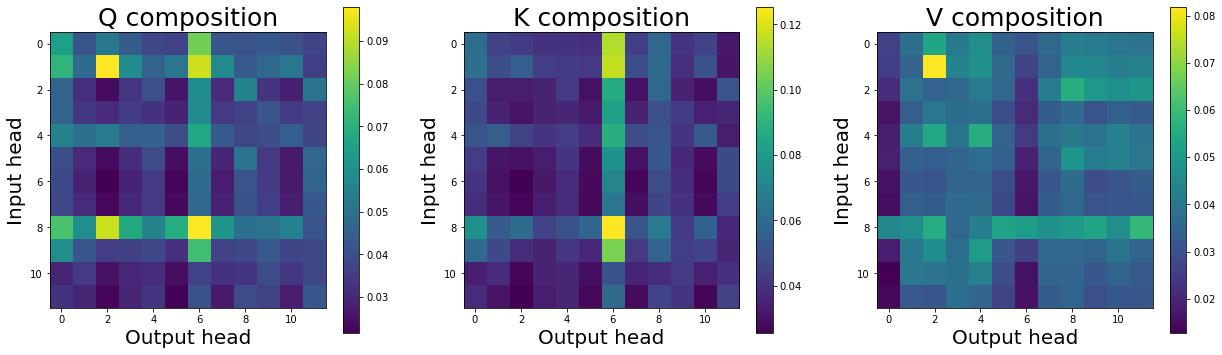

In [ ]:
plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
plt.title("Q composition", fontsize=25)
plt.imshow(Qcomps)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 2)
plt.title("K composition", fontsize=25)
plt.imshow(Kcomps)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()


plt.subplot(1, 3, 3)
plt.title("V composition", fontsize=25)
plt.imshow(Vcomps)

plt.xlabel("Output head", fontsize=20)
plt.ylabel("Input head", fontsize=20)
plt.colorbar()

plt.show()

In [ ]:
Qcomps.mean(), Kcomps.mean(), Vcomps.mean()

(0.04180071, 0.04470787, 0.03609171)

In [ ]:
att0 = model.transformer.h[0].attn.attention

U, S, Vt = np.linalg.svd(att0.q_proj.weight.data.numpy())

In [ ]:
att0.q_proj.weight.data.numpy().shape

(768, 768)

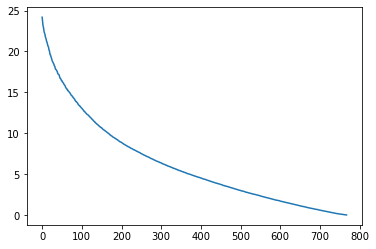

In [ ]:
plt.plot(S)

plt.show()

In [ ]:
QK = gptneo.QK(model, 0, 0)

In [ ]:
U, S, Vt = np.linalg.svd(QK)

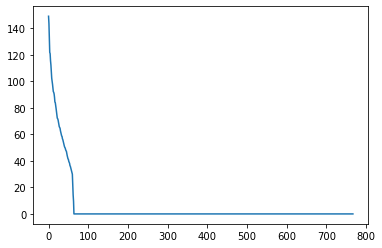

In [ ]:
plt.plot(S)

plt.show()

In [ ]:
model.config.num_layers

12

In [ ]:
model.config.num_heads

12

In [ ]:
qk_ranks = list()
for i in range(12):
    for j in range(12):
        qk_ranks.append(np.linalg.matrix_rank(gptneo.QK(model, i, j)))

In [ ]:
ov_ranks = list()
for i in range(12):
    for j in range(12):
        ov_ranks.append(np.linalg.matrix_rank(gptneo.OV_simple(model, i, j)))

In [ ]:
from collections import Counter
Counter(ranks)

NameError: name 'ranks' is not defined

In [ ]:
Counter(ov_ranks)

In [ ]:
(768 X 64) @ (64 X 768)

In [ ]:
UAx = Uhx

In [ ]:
S.shape